<a href="https://colab.research.google.com/github/nitishast/TF/blob/master/Toxic_comment_classification_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
#python 3.6
#anaconda 5.1.0 windows-x86 64 exe
#tensorflow==1.12.0
#Keras==2.2.4
#https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras

In [0]:
train = pd.read_csv("train_preprocessed.csv")
test = pd.read_csv("test_preprocessed.csv")

In [0]:
test.head(2)

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity
0,yo bitch ja rule is more succesful then you ll...,00001cee341fdb12,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN
1,from rfc the title is fine as it is imo,0000247867823ef7,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN


In [0]:
test.isnull().any(), train.isnull().any()

(comment_text      True
 id               False
 identity_hate     True
 insult            True
 obscene           True
 set              False
 severe_toxic      True
 threat            True
 toxic             True
 toxicity          True
 dtype: bool, comment_text     False
 id               False
 identity_hate    False
 insult           False
 obscene          False
 set              False
 severe_toxic     False
 threat           False
 toxic            False
 toxicity         False
 dtype: bool)

## checking for null values and filling it with something

In [0]:
test = test.replace(np.nan, '', regex=True)

Splitting the train dataset into X & Y with features(imp)

In [0]:
list_classes = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
y = train[list_classes].values
list_sentences_train= train["comment_text"]
list_sentences_test= test["comment_text"]

Using tokenising forming adictionary of words in the comment and then feeding to the LSTM 

In [0]:
max_features =20000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test  = tokenizer.texts_to_sequences(list_sentences_test)


##Checking the dict and indexes of words. Keras does this thing in 4 lines of code.

In [0]:
#for occurence of words
tokenizer.word_counts
#for index of words
tokenizer.word_index

In [0]:
list_tokenized_train[:2]

### we use "padding"! We could make the shorter sentences as long as the others by filling the shortfall by zeros.But on the other hand, we also have to trim the longer ones to the same length(maxlen) as the short ones. In this case, we have set the max length to be 200.

In [0]:
max_length = 200
X_t = pad_sequences(list_tokenized_train,maxlen=max_length)
X_te= pad_sequences(list_tokenized_test,maxlen=max_length)


### Note: How to set the perfect max length for the comments. les lenght looses out on feature and more length increases the cell size of LSTM

In [0]:
totalnumwords = [len(one_comment) for one_comment in list_tokenized_train]
totalnumwords

## categorising the comments lenght in bins and then plotting a histogram to see the distributions. 

(array([21647., 26776., 21885., 16161., 12809.,  9996.,  7679.,  6073.,
         4693.,  3907.,  3280.,  2733.,  2370.,  1939.,  1665.,  1511.,
         1323.,  1251.,  1081.,   875.,   778.,   772.,   590.,   567.,
          534.,   483.,   442.,   360.,   380.,   279.,   266.,   236.,
          222.,   202.,   138.,   155.,   155.,   149.,   140.,   136.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400]),
 <a list of 40 Patch objects>)

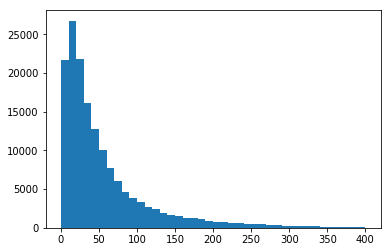

In [0]:
plt.hist(totalnumwords,bins = np.arange(0,410,10))# creating bins and then plotting the comments length

# Building the model!

## Beginining by creating an input layer which accepts a list of sentences which has dimensions  200

In [0]:
#By indicating an empty space after comma, we are telling Keras to infer the number automatically.
inp = Input(shape=(max_length, )) 

#### We need to define the size of the "vector space" we have mentioned above, and the number of unique words(max_features) we are using. Again, the embedding size is a parameter that you can tune and experiment.

####The output of the Embedding layer is just a list of the coordinates of the words in this vector space. For eg. (-81.012) for "cat" and (-80.012) for "dog". We could also use the distance of these coordinates to detect relevance and context.

In [0]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

Instructions for updating:
Colocations handled automatically by placer.


https://medium.com/@quantumsteinke/whats-the-difference-between-a-matrix-and-a-tensor-4505fbdc576c

### Next, we feed this Tensor into the LSTM layer. We set the LSTM to produce an output that has a dimension of 60 and want it to return the whole unrolled sequence of results. As you probably know, LSTM or RNN works by recursively feeding the output of a previous network into the input of the current network, and you would take the final output after X number of recursion. But depending on use cases, you might want to take the unrolled, or the outputs of each recursion as the result to pass to the next layer. 

LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs].


1.  **Batch size** is the number of samples in a batch.
2.   **time steps** is the number of recursion it runs for each input, or it could be pictured as the number of "A"s in the above picture. Lastly,
3.  **number of inputs** is the number of variables(number of words in each sentence in our case) you pass into LSTM as pictured in "x" above.

In [0]:
X = LSTM(60,return_sequences=True,name ='lstm_layer')(x)

## Before we could pass the output to a normal layer, we need to reshape the 3D tensor into a 2D one. We reshape carefully to avoid throwing away data that is important to us, and ideally we want the resulting data to be a good representative of the original data.

### Global Max Pooling layer which is traditionally used in CNN problems to reduce the dimensionality of image data. In simple terms, we go through each patch of data, and we take the maximum values of each patch. These collection of maximum values will be a new set of down-sized data we can use

In [0]:
x = GlobalMaxPool1D()(x)

## Purpose of using DROPOUTS is:
### We use dropout which indiscriminaterly disables some nodes so that nodes in the next layer is forces to handle the representation of missing data and the whole network could result in better generalisation 


#### dropping 10% of nodes i.e. 01.**bold text**

In [0]:
x = Dropout(0.1)(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


We pass the output of dropout layer to a dense layer and output passes through a RELU function 
## Activation((Input * Weights) + Bias )

In [0]:
x = Dense(50, activation="relu")(x)

Passing the output to a dropout layer again

In [0]:
x = Dropout(0.1)(x)

### Finally passing this through a sigmoid funtion because we are trying to get the binary classification[0,1] 


In [0]:
x = Dense(6,activation="sigmoid")(x)

## Final steps: We are almost done! All is left is to define the inputs, outputs and configure the learning process

In [0]:
model = Model(inputs=inp,outputs=x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
y


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [0]:
## Fitting the model with the train and test data sets. 
batch_size = 32
epochs = 2
model.fit(X_t,y,batch_size=batch_size, epochs=epochs,validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 211s 1ms/step - loss: 0.0784 - acc: 0.9750 - val_loss: 0.0524 - val_acc: 0.9806
Epoch 2/2
143613/143613 [==============================] - 215s 1ms/step - loss: 0.0486 - acc: 0.9817 - val_loss: 0.0490 - val_acc: 0.9814


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total para

## To checkfor the output of a layer 

In [0]:
from keras import backend as k

In [0]:
get_3rd_layer_output = k.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape

(1, 128)

In [0]:
layer_output

array([[ 0.23875104,  0.23650843,  0.3112663 ,  0.34676412,  0.20881711,
         0.17066254,  0.11643857,  0.2304166 ,  0.19209792,  0.2614349 ,
         0.19999133,  0.24715362,  0.16751418,  0.14775519,  0.30145276,
         0.16050819,  0.05825273,  0.23378319,  0.08095463,  0.07447441,
         0.33564535,  0.11166231,  0.14661536,  0.11577816,  0.21770659,
         0.18335508,  0.03967449,  0.09699484,  0.11953064,  0.17595844,
         0.14694695,  0.2698373 ,  0.19930907,  0.20590563,  0.08537367,
         0.08944958,  0.14104222,  0.03034097,  0.22312653,  0.22423673,
         0.20940095,  0.11245004,  0.23824592,  0.31857327,  0.1066708 ,
        -0.01256714,  0.05947236,  0.3252051 ,  0.19234265,  0.3188555 ,
         0.1980141 ,  0.3477846 ,  0.0990883 ,  0.19465815,  0.12949577,
         0.12626562,  0.21397322,  0.23058526,  0.10364183,  0.12151866,
         0.18776198,  0.07451349,  0.24807397,  0.2517806 ,  0.45864856,
         0.13077365,  0.1599024 , -0.00476002,  0.2